import zipfile
with zipfile.ZipFile('custom.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Siamese Neural Network

Siamese neural network is a class of neural network architectures that contain two or more identical sub networks. identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub networks.It is used find the similarity of the inputs by comparing its feature vectors.

For more details check this blog : https://innovationincubator.com/siamese-neural-network-with-code-example/

## Steps to create classifier using Siamese Neural Network 


1.   **Data Preprocessing**
2.   **Define the Siamese Network**
3.   **Feature Vector Extraction**
4.   **Similarity Score Calculation**
5.   **Defininf Loss Function**
6.   **Optimizer**
7.   **Testing using One-Shot Learnig**
8.   **Making Predictions**



Let's  go step wise 

## Import and Install all the necessary packages

In [1]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
from sklearn.model_selection import train_test_split
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (15,15)

In [2]:
path = './custom/full'

In [89]:
data = pd.DataFrame()

folders = os.listdir('./custom/full')
folders.sort()
folders = folders[:128]
for x in tqdm(range(0,len(folders),2)):
    for y in os.listdir(path + '/' + folders[x]):
        for z in os.listdir(path + '/' + folders[x]):
            if y != z:
                data = data.append([[str(folders[x]) + '/' + y, str(folders[x]) + '/' + z, 0]])
                
for x in tqdm(range(0,len(folders),2)):
    for y in os.listdir(path + '/' + folders[x]):
        for z in os.listdir(path + '/' + folders[x] + '_forg'):
            data = data.append([[str(folders[x]) + '/' + y, str(folders[x]) + '_forg' + '/' + z, 1]])

data.to_csv('./custom/data.csv',index=False)
data.head(10)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

,0,1,2
0,001/001_07.png,001/001_13.png,0
0,001/001_07.png,001/001_19.png,0
0,001/001_07.png,001/001_15.png,0
0,001/001_07.png,001/001_05.png,0
0,001/001_07.png,001/001_16.png,0
0,001/001_07.png,001/001_06.png,0
0,001/001_07.png,001/001_21.png,0
0,001/001_07.png,001/001_20.png,0
0,001/001_07.png,001/001_02.png,0
0,001/001_07.png,001/001_12.png,0


### Additional Utility Functions 

In [90]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Statified Split

In [115]:
data = pd.read_csv('./custom/data.csv').sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,[0,1]],data.iloc[:,[2]],test_size=0.3,stratify=data.iloc[:,2])
pd.concat([X_train,y_train],axis=1).to_csv('./custom/train_data.csv',index=False)
pd.concat([X_test,y_test],axis=1).to_csv('./custom/test_data.csv',index=False)

data = pd.read_csv('./custom/test_data.csv').sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,[0,1]],data.iloc[:,[2]],test_size=0.5,stratify=data.iloc[:,2])
pd.concat([X_train,y_train],axis=1).to_csv('./custom/test_data.csv',index=False)
pd.concat([X_test,y_test],axis=1).to_csv('./custom/val_data.csv',index=False)

In [94]:
class Config():
    data_dir = "./model"
    train_batch_size = 32
    train_number_epochs = 50

## Load Dataset :

Datasets can be downloaded from this Link:  https://drive.google.com/file/d/1q03FLpaolm6Jq5vM0a_AEnjJoqjtxgP8/view?usp=sharing

**Copy the dataset directly to your drive and load it from there**

In [95]:
data_dir = "./custom/full"
training_csv = "./custom/train_data.csv"
testing_csv = "./custom/test_data.csv"

### Preprocessing and Loading Dataset

We preprocessed all the images and loaded them as .npy files which is easy to transfer . You can follow your own preprocessing steps .


In [96]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        #print(image1_path,image2_path)
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [97]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,data_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      #transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

torch.Size([8, 1, 105, 105])


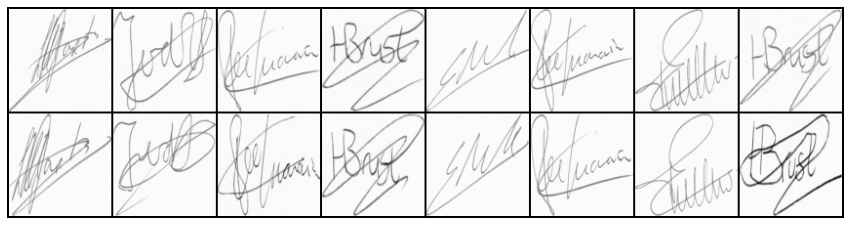

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [100]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
print(example_batch[0].size())
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Siamese Network Definition

In [32]:
class SiameseNetwork1(nn.Module):
    def __init__(self):
        super(SiameseNetwork1, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(                                    # 1 x 105 x 105
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),                # 96 x 95 x 95
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),                                # 96 x 47 x 47
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),     # 256 x 47 x 47
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),                                # 256 x 23 x 23
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),    # 384 x 23 x 23
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),    # 256 x 23 x 23
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),                                # 256 x 11 x 11
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [101]:
class SiameseNetwork2(nn.Module):
    def __init__(self):
        super(SiameseNetwork2, self).__init__()
        self.cnn1 = nn.Sequential(              # 1 x 105 x 105
            nn.Conv2d(1, 20, kernel_size=5),    # 20 x 101 x 101
            nn.MaxPool2d(3, stride=2),          # 20 x 50 x 50
            nn.Conv2d(20, 50, kernel_size=5),   # 50 x 46 x 46
            nn.MaxPool2d(2, stride=2))          # 50 x 23 x 23
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 23 * 23, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,10))
            #nn.Linear(10, 2))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [53]:
class SiameseNetwork3(nn.Module):
    def __init__(self):
        super(SiameseNetwork3, self).__init__()                                # 1 x 105 x 105
        
        self.conv1=nn.Conv2d(1,50,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L1 ImgIn shape=(?, 28, 28, 1)      # (n-f+2*p/s)+1
        #    Conv     -> (?, 24, 24, 50)
        #    Pool     -> (?, 12, 12, 50)
        
        
        self.conv2 = nn.Conv2d(50,60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L2 ImgIn shape=(?, 12, 12, 50)
        #    Conv      ->(?, 8, 8, 60)
        #    Pool      ->(?, 4, 4, 60)
        
        
        self.conv3 = nn.Conv2d(60, 80,  kernel_size = 3)
        # L3 ImgIn shape=(?, 4, 4, 60)
        #    Conv      ->(?, 2, 2, 80)
        
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(60)
        
        #self.dropout1 = nn.Dropout2d()
        
        # L4 FC 2*2*80 inputs -> 250 outputs
        self.fc1 = nn.Linear(32000, 128) 
        self.fc2 = nn.Linear(128, 2)
        
    def forward_once(self, x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x=self.pool1(x)
        
        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x=self.pool2(x)
        
        x=self.conv3(x)
        x=F.relu(x)
#         print(x.size())
        x = x.view(x.size()[0], -1)
#         print('Output2')
#         print(x.size()) #32000 thats why the input of fully connected layer is 32000
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

    def forward(self, x, y):
        # forward pass of input 1
        output1 = self.forward_once(x)
        # forward pass of input 2
        output2 = self.forward_once(y)
        
        return output1, output2

### Loss Function

In [102]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        #loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        #loss_contrastive = torch.sum(loss_contrastive) / 2.0 / output1.size()[0]
        return loss_contrastive

### Plot

In [103]:
def plot_loss(train_loss):
    plt.plot(train_loss, label="train loss")
    plt.legend()

### Train the Model

In [104]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [105]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [106]:
def train(net,criterion):
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
            if i %100 == 0 :
                print("Epoch number {}\n Current loss {}\n Learning Rate {}\n".format(epoch,loss_contrastive.item(),optimizer.param_groups[0]['lr']))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
        
        #if scheduler!=None:
            #scheduler.step()
    
    return net,loss_history

### Model 1 - Accuracy - 50

In [62]:
# Declare Siamese Network
net1 = SiameseNetwork1().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net1.parameters(), lr=0.00001, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.8)
#optimizer = torch.optim.SGD(net1.parameters(), lr=0.00001, momentum=0.8)

NameError: name 'SiameseNetwork1' is not defined

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model1,loss_history1 = train(net1,criterion)
torch.save(model1.state_dict(), "./model/model1.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 0.007746732793748379

Epoch number 0
 Current loss 0.004989439155906439

Epoch number 0
 Current loss 0.005183550529181957

Epoch number 0
 Current loss 0.005321804899722338

Epoch number 0
 Current loss 0.004775776527822018

Epoch number 0
 Current loss 0.0047976355999708176

Epoch number 0
 Current loss 0.003689951030537486

Epoch number 0
 Current loss 0.004905028268694878

Epoch number 0
 Current loss 0.004258079454302788

Epoch number 0
 Current loss 0.004683276172727346

Epoch number 0
 Current loss 0.004218813963234425

Epoch number 0
 Current loss 0.003991723991930485

Epoch number 0
 Current loss 0.004769997671246529

Epoch number 0
 Current loss 0.004503864794969559

Epoch number 0
 Current loss 0.004791460931301117

Epoch number 0
 Current loss 0.005162735469639301

Epoch number 0
 Current loss 0.004952081013470888

Epoch number 0
 Current loss 0.005160066299140453

Epoch number 0
 Current loss 0.004751875065267086

Epoch number 0
 Current loss 0

Epoch number 3
 Current loss 0.0046869614161551

Epoch number 3
 Current loss 0.005061456933617592

Epoch number 3
 Current loss 0.005162464454770088

Epoch number 3
 Current loss 0.0049202400259673595

Epoch number 3
 Current loss 0.005134017206728458

Epoch number 3
 Current loss 0.004655224271118641

Epoch number 3
 Current loss 0.004811245948076248

Epoch number 3
 Current loss 0.004628078080713749

Epoch number 3
 Current loss 0.0048308782279491425

Epoch number 3
 Current loss 0.004319232888519764

Epoch number 3
 Current loss 0.004806815646588802

Epoch number 3
 Current loss 0.004824562463909388

Epoch number 3
 Current loss 0.004372864495962858

Epoch number 3
 Current loss 0.004775557667016983

Epoch number 3
 Current loss 0.004600186832249165

Epoch number 3
 Current loss 0.004424612037837505

Epoch number 3
 Current loss 0.004487460944801569

Epoch number 3
 Current loss 0.004843809641897678

Epoch number 3
 Current loss 0.004827645607292652

Epoch number 3
 Current loss 0.

Epoch number 6
 Current loss 0.004508481360971928

Epoch number 6
 Current loss 0.004269789904356003

Epoch number 6
 Current loss 0.004426426254212856

Epoch number 6
 Current loss 0.004940709099173546

Epoch number 6
 Current loss 0.0045290542766451836

Epoch number 6
 Current loss 0.0044572483748197556

Epoch number 6
 Current loss 0.005293315276503563

Epoch number 6
 Current loss 0.004746156744658947

Epoch number 6
 Current loss 0.005425612907856703

Epoch number 6
 Current loss 0.004613589961081743

Epoch number 6
 Current loss 0.004215513356029987

Epoch number 6
 Current loss 0.0046457890421152115

Epoch number 6
 Current loss 0.00453287735581398

Epoch number 7
 Current loss 0.004628742579370737

Epoch number 7
 Current loss 0.00411054864525795

Epoch number 7
 Current loss 0.004644798114895821

Epoch number 7
 Current loss 0.004815414547920227

Epoch number 7
 Current loss 0.004675074480473995

Epoch number 7
 Current loss 0.004750692285597324

Epoch number 7
 Current loss 0

Epoch number 10
 Current loss 0.004734695889055729

Epoch number 10
 Current loss 0.005165367852896452

Epoch number 10
 Current loss 0.0046652527526021

Epoch number 10
 Current loss 0.00432727811858058

Epoch number 10
 Current loss 0.005463926121592522

Epoch number 10
 Current loss 0.004068699665367603

Epoch number 10
 Current loss 0.003823639824986458

Epoch number 10
 Current loss 0.004743762314319611

Epoch number 10
 Current loss 0.004632432479411364

Epoch number 10
 Current loss 0.004699311684817076

Epoch number 10
 Current loss 0.004288347437977791

Epoch number 10
 Current loss 0.004418222699314356

Epoch number 10
 Current loss 0.004548284225165844

Epoch number 10
 Current loss 0.0048843491822481155

Epoch number 10
 Current loss 0.004497501999139786

Epoch number 10
 Current loss 0.005371152423322201

Epoch number 10
 Current loss 0.004363182466477156

Epoch number 10
 Current loss 0.004523048177361488

Epoch number 10
 Current loss 0.004598310217261314

Epoch number 1

Epoch number 13
 Current loss 0.0044718775898218155

Epoch number 13
 Current loss 0.004632896743714809

Epoch number 13
 Current loss 0.00511705968528986

Epoch number 13
 Current loss 0.004408578388392925

Epoch number 13
 Current loss 0.004438639618456364

Epoch number 13
 Current loss 0.004287297837436199

Epoch number 13
 Current loss 0.004607501905411482

Epoch number 13
 Current loss 0.004247174598276615

Epoch number 13
 Current loss 0.004733782261610031

Epoch number 13
 Current loss 0.004944727756083012

Epoch number 13
 Current loss 0.0045520830899477005

Epoch number 13
 Current loss 0.004788883030414581

Epoch number 13
 Current loss 0.005040428135544062

Epoch number 13
 Current loss 0.0047564031556248665

Epoch number 13
 Current loss 0.004780944436788559

Epoch number 13
 Current loss 0.005331983789801598

Epoch number 13
 Current loss 0.00474060932174325

Epoch number 13
 Current loss 0.004449544940143824

Epoch number 13
 Current loss 0.004372905939817429

Epoch numbe

Epoch number 16
 Current loss 0.00477018766105175

Epoch number 16
 Current loss 0.005158097483217716

Epoch number 16
 Current loss 0.004487849771976471

Epoch number 16
 Current loss 0.004567346069961786

Epoch number 16
 Current loss 0.004553803242743015

Epoch number 16
 Current loss 0.004032611381262541

Epoch number 16
 Current loss 0.004298293963074684

Epoch number 16
 Current loss 0.0046771131455898285

Epoch number 16
 Current loss 0.005235988646745682

Epoch number 16
 Current loss 0.004923539701849222

Epoch number 16
 Current loss 0.004976113326847553

Epoch number 16
 Current loss 0.004541914444416761

Epoch number 16
 Current loss 0.0042513953521847725

Epoch number 16
 Current loss 0.004893414676189423

Epoch number 16
 Current loss 0.004906295798718929

Epoch number 17
 Current loss 0.004426170606166124

Epoch number 17
 Current loss 0.0046143378131091595

Epoch number 17
 Current loss 0.005046994891017675

Epoch number 17
 Current loss 0.004620303399860859

Epoch numb

Epoch number 19
 Current loss 0.00474994070827961

Epoch number 20
 Current loss 0.003997609950602055

Epoch number 20
 Current loss 0.004885002039372921

Epoch number 20
 Current loss 0.004507957957684994

Epoch number 20
 Current loss 0.00481033232063055

Epoch number 20
 Current loss 0.00475677102804184

Epoch number 20
 Current loss 0.00442308746278286

Epoch number 20
 Current loss 0.004803628660738468

Epoch number 20
 Current loss 0.005128479562699795

Epoch number 20
 Current loss 0.004607137758284807

Epoch number 20
 Current loss 0.004533075727522373

Epoch number 20
 Current loss 0.004439583048224449

Epoch number 20
 Current loss 0.004577892832458019

Epoch number 20
 Current loss 0.00453172717243433

Epoch number 20
 Current loss 0.004632314667105675

Epoch number 20
 Current loss 0.0049949283711612225

Epoch number 20
 Current loss 0.0041138906963169575

Epoch number 20
 Current loss 0.004925037734210491

Epoch number 20
 Current loss 0.004286901094019413

Epoch number 20

Epoch number 23
 Current loss 0.004469360690563917

Epoch number 23
 Current loss 0.004174965433776379

Epoch number 23
 Current loss 0.004568859934806824

Epoch number 23
 Current loss 0.004735592752695084

Epoch number 23
 Current loss 0.004653500858694315

Epoch number 23
 Current loss 0.004284602589905262

Epoch number 23
 Current loss 0.00418209470808506

Epoch number 23
 Current loss 0.005300047807395458

Epoch number 23
 Current loss 0.004657245706766844

Epoch number 23
 Current loss 0.004181668162345886

Epoch number 23
 Current loss 0.004844510927796364

Epoch number 23
 Current loss 0.0053581129759550095

Epoch number 23
 Current loss 0.004291327204555273

Epoch number 23
 Current loss 0.0045782397501170635

Epoch number 23
 Current loss 0.005046783946454525

Epoch number 23
 Current loss 0.004468838684260845

Epoch number 23
 Current loss 0.005002889782190323

Epoch number 23
 Current loss 0.005147701129317284

Epoch number 23
 Current loss 0.004618422128260136

Epoch numbe

Epoch number 26
 Current loss 0.004877910017967224

Epoch number 26
 Current loss 0.004496541805565357

Epoch number 26
 Current loss 0.0045298440381884575

Epoch number 26
 Current loss 0.0045175859704613686

Epoch number 26
 Current loss 0.004799750167876482

Epoch number 26
 Current loss 0.004879179410636425

Epoch number 26
 Current loss 0.00407622242346406

Epoch number 26
 Current loss 0.005117012187838554

Epoch number 26
 Current loss 0.0043902164325118065

Epoch number 26
 Current loss 0.004511445295065641

Epoch number 26
 Current loss 0.004283502232283354

Epoch number 26
 Current loss 0.004629670642316341

Epoch number 26
 Current loss 0.00446070171892643

Epoch number 26
 Current loss 0.00440946826711297

Epoch number 26
 Current loss 0.005071407649666071

Epoch number 26
 Current loss 0.004877414554357529

Epoch number 26
 Current loss 0.004437682218849659

Epoch number 26
 Current loss 0.00491997180506587

Epoch number 26
 Current loss 0.004966329783201218

Epoch number 

Epoch number 29
 Current loss 0.004839334636926651

Epoch number 29
 Current loss 0.004697407595813274

Epoch number 29
 Current loss 0.0051027704030275345

Epoch number 29
 Current loss 0.004425805062055588

Epoch number 30
 Current loss 0.004450105596333742

Epoch number 30
 Current loss 0.00463518500328064

Epoch number 30
 Current loss 0.004715054761618376

Epoch number 30
 Current loss 0.004049891140311956

Epoch number 30
 Current loss 0.0045500583946704865

Epoch number 30
 Current loss 0.005160118453204632

Epoch number 30
 Current loss 0.005169843323528767

Epoch number 30
 Current loss 0.004836904350668192

Epoch number 30
 Current loss 0.003958241082727909

Epoch number 30
 Current loss 0.004724154248833656

Epoch number 30
 Current loss 0.004309928044676781

Epoch number 30
 Current loss 0.005368397571146488

Epoch number 30
 Current loss 0.005474841222167015

Epoch number 30
 Current loss 0.004559402819722891

Epoch number 30
 Current loss 0.00453655980527401

Epoch number

Epoch number 33
 Current loss 0.004748526494950056

Epoch number 33
 Current loss 0.00438444409519434

Epoch number 33
 Current loss 0.004667025059461594

Epoch number 33
 Current loss 0.004796773195266724

Epoch number 33
 Current loss 0.004704488441348076

Epoch number 33
 Current loss 0.0046442290768027306

Epoch number 33
 Current loss 0.004744775593280792

Epoch number 33
 Current loss 0.004247017204761505

Epoch number 33
 Current loss 0.004849997349083424

Epoch number 33
 Current loss 0.004133916925638914

Epoch number 33
 Current loss 0.004413877613842487

Epoch number 33
 Current loss 0.004572038073092699

Epoch number 33
 Current loss 0.004942101426422596

Epoch number 33
 Current loss 0.0044793011620640755

Epoch number 33
 Current loss 0.004449060186743736

Epoch number 33
 Current loss 0.004679768346250057

Epoch number 33
 Current loss 0.004501810297369957

Epoch number 33
 Current loss 0.004537930246442556

Epoch number 33
 Current loss 0.004698238801211119

Epoch numbe

Epoch number 36
 Current loss 0.005111778154969215

Epoch number 36
 Current loss 0.0047057149931788445

Epoch number 36
 Current loss 0.004764295183122158

Epoch number 36
 Current loss 0.004486717749387026

Epoch number 36
 Current loss 0.005306712351739407

Epoch number 36
 Current loss 0.0046045901253819466

Epoch number 36
 Current loss 0.00486108660697937

Epoch number 36
 Current loss 0.0044876933097839355

Epoch number 36
 Current loss 0.004407175816595554

Epoch number 36
 Current loss 0.004656493663787842

Epoch number 36
 Current loss 0.0048284647054970264

Epoch number 36
 Current loss 0.00492298137396574

Epoch number 36
 Current loss 0.004899835214018822

Epoch number 36
 Current loss 0.004416175186634064

Epoch number 36
 Current loss 0.004891978111118078

Epoch number 36
 Current loss 0.00454351119697094

Epoch number 36
 Current loss 0.004682887811213732

Epoch number 36
 Current loss 0.004842706955969334

Epoch number 36
 Current loss 0.004508460406213999

Epoch numbe

Epoch number 39
 Current loss 0.004852217622101307

Epoch number 39
 Current loss 0.004510583356022835

Epoch number 39
 Current loss 0.00445398036390543

Epoch number 39
 Current loss 0.0043714893981814384

Epoch number 39
 Current loss 0.004798985086381435

Epoch number 39
 Current loss 0.004644892644137144

Epoch number 39
 Current loss 0.0042827497236430645

Epoch number 40
 Current loss 0.004797697998583317

Epoch number 40
 Current loss 0.004417060408741236

Epoch number 40
 Current loss 0.004468425177037716

Epoch number 40
 Current loss 0.004196295514702797

Epoch number 40
 Current loss 0.005926037207245827

Epoch number 40
 Current loss 0.004836549982428551

Epoch number 40
 Current loss 0.005236545577645302

Epoch number 40
 Current loss 0.0045184968039393425

Epoch number 40
 Current loss 0.004752459470182657

Epoch number 40
 Current loss 0.004709507804363966

Epoch number 40
 Current loss 0.004622252658009529

Epoch number 40
 Current loss 0.004218028858304024

Epoch numb

Epoch number 43
 Current loss 0.0048211850225925446

Epoch number 43
 Current loss 0.004705165047198534

Epoch number 43
 Current loss 0.00468884501606226

Epoch number 43
 Current loss 0.004536758176982403

Epoch number 43
 Current loss 0.004219541326165199

Epoch number 43
 Current loss 0.00463330140337348

Epoch number 43
 Current loss 0.0044374484568834305

Epoch number 43
 Current loss 0.004960280377417803

Epoch number 43
 Current loss 0.004218620713800192

Epoch number 43
 Current loss 0.005003352649509907

Epoch number 43
 Current loss 0.004573462530970573

Epoch number 43
 Current loss 0.004713824484497309

Epoch number 43
 Current loss 0.004930510185658932

Epoch number 43
 Current loss 0.004992062225937843

Epoch number 43
 Current loss 0.004596680868417025

Epoch number 43
 Current loss 0.004229300655424595

Epoch number 43
 Current loss 0.0049131037667393684

Epoch number 43
 Current loss 0.004567550029605627

Epoch number 43
 Current loss 0.0045103346928954124

Epoch numb

Epoch number 46
 Current loss 0.005241130478680134

Epoch number 46
 Current loss 0.00385750038549304

Epoch number 46
 Current loss 0.0053289541974663734

Epoch number 46
 Current loss 0.004645528271794319

Epoch number 46
 Current loss 0.004334180615842342

Epoch number 46
 Current loss 0.004749448969960213

Epoch number 46
 Current loss 0.004408048931509256

Epoch number 46
 Current loss 0.0051963659934699535

Epoch number 46
 Current loss 0.004457656294107437

Epoch number 46
 Current loss 0.004328584764152765

Epoch number 46
 Current loss 0.004603532142937183

Epoch number 46
 Current loss 0.004646708257496357

Epoch number 46
 Current loss 0.004958455450832844

Epoch number 46
 Current loss 0.004886268638074398

Epoch number 46
 Current loss 0.004171534441411495

Epoch number 46
 Current loss 0.005014005117118359

Epoch number 46
 Current loss 0.004237084649503231

Epoch number 46
 Current loss 0.004092098213732243

Epoch number 46
 Current loss 0.004619012586772442

Epoch numbe

Epoch number 49
 Current loss 0.0044286916963756084

Epoch number 49
 Current loss 0.0048169298097491264

Epoch number 49
 Current loss 0.0047864303924143314

Epoch number 49
 Current loss 0.005056868772953749

Epoch number 49
 Current loss 0.004947686567902565

Epoch number 49
 Current loss 0.0051957303658127785

Epoch number 49
 Current loss 0.004238772206008434

Epoch number 49
 Current loss 0.0045060887932777405

Epoch number 49
 Current loss 0.004467684775590897

Epoch number 49
 Current loss 0.004794354550540447

Epoch number 49
 Current loss 0.004413445480167866

Epoch number 49
 Current loss 0.0046213120222091675

Epoch number 50
 Current loss 0.004794275853782892

Epoch number 50
 Current loss 0.004705330822616816

Epoch number 50
 Current loss 0.005239523947238922

Epoch number 50
 Current loss 0.004662902094423771

Epoch number 50
 Current loss 0.004838811233639717

Epoch number 50
 Current loss 0.004469640552997589

Epoch number 50
 Current loss 0.004419182427227497

Epoch 

Epoch number 53
 Current loss 0.004130559973418713

Epoch number 53
 Current loss 0.004693861585110426

Epoch number 53
 Current loss 0.0050710770301520824

Epoch number 53
 Current loss 0.004491905681788921

Epoch number 53
 Current loss 0.005083323456346989

Epoch number 53
 Current loss 0.00496460497379303

Epoch number 53
 Current loss 0.004537936300039291

Epoch number 53
 Current loss 0.004870996810495853

Epoch number 53
 Current loss 0.004862540867179632

Epoch number 53
 Current loss 0.004902029410004616

Epoch number 53
 Current loss 0.004513658583164215

Epoch number 53
 Current loss 0.004577618092298508

Epoch number 53
 Current loss 0.004416787065565586

Epoch number 53
 Current loss 0.004852708429098129

Epoch number 53
 Current loss 0.00457422062754631

Epoch number 53
 Current loss 0.004747231490910053

Epoch number 53
 Current loss 0.005153489299118519

Epoch number 53
 Current loss 0.004895113408565521

Epoch number 53
 Current loss 0.004784115590155125

Epoch number 

Epoch number 56
 Current loss 0.004935231991112232

Epoch number 56
 Current loss 0.005378728732466698

Epoch number 56
 Current loss 0.0042469436302781105

Epoch number 56
 Current loss 0.004605918191373348

Epoch number 56
 Current loss 0.004844251088798046

Epoch number 56
 Current loss 0.004705604165792465

Epoch number 56
 Current loss 0.004660408012568951

Epoch number 56
 Current loss 0.005205288529396057

Epoch number 56
 Current loss 0.004420429468154907

Epoch number 56
 Current loss 0.004734850022941828

Epoch number 56
 Current loss 0.00461312010884285

Epoch number 56
 Current loss 0.005340425297617912

Epoch number 56
 Current loss 0.004686849657446146

Epoch number 56
 Current loss 0.004660631529986858

Epoch number 56
 Current loss 0.004682866856455803

Epoch number 56
 Current loss 0.0043837144039571285

Epoch number 56
 Current loss 0.004592321813106537

Epoch number 56
 Current loss 0.004583129659295082

Epoch number 56
 Current loss 0.0048904456198215485

Epoch numb

Epoch number 59
 Current loss 0.004575233906507492

Epoch number 59
 Current loss 0.006007098592817783

Epoch number 59
 Current loss 0.004592925310134888

Epoch number 59
 Current loss 0.004478940740227699

Epoch number 59
 Current loss 0.004773166496306658

Epoch number 59
 Current loss 0.004408078268170357

Epoch number 59
 Current loss 0.005645752418786287

Epoch number 59
 Current loss 0.004938503727316856

Epoch number 59
 Current loss 0.004659939557313919

Epoch number 59
 Current loss 0.004687992390245199

Epoch number 59
 Current loss 0.004617020487785339

Epoch number 59
 Current loss 0.004524297080934048

Epoch number 59
 Current loss 0.004638378508388996

Epoch number 59
 Current loss 0.00463089719414711

Epoch number 60
 Current loss 0.004630748648196459

Epoch number 60
 Current loss 0.005090827122330666

Epoch number 60
 Current loss 0.004241464659571648

Epoch number 60
 Current loss 0.004716641269624233

Epoch number 60
 Current loss 0.005228184163570404

Epoch number 

Epoch number 63
 Current loss 0.005431387573480606

Epoch number 63
 Current loss 0.004874236881732941

Epoch number 63
 Current loss 0.004547290038317442

Epoch number 63
 Current loss 0.00469526182860136

Epoch number 63
 Current loss 0.004509507678449154

Epoch number 63
 Current loss 0.004208789207041264

Epoch number 63
 Current loss 0.004549138247966766

Epoch number 63
 Current loss 0.003937528934329748

Epoch number 63
 Current loss 0.004454272799193859

Epoch number 63
 Current loss 0.00436869403347373

Epoch number 63
 Current loss 0.0042220959439873695

Epoch number 63
 Current loss 0.004741756711155176

Epoch number 63
 Current loss 0.004671670030802488

Epoch number 63
 Current loss 0.004177490249276161

Epoch number 63
 Current loss 0.005172212142497301

Epoch number 63
 Current loss 0.004358988255262375

Epoch number 63
 Current loss 0.004698031581938267

Epoch number 63
 Current loss 0.0046708472073078156

Epoch number 63
 Current loss 0.004733718000352383

Epoch number

Epoch number 66
 Current loss 0.00473531149327755

Epoch number 66
 Current loss 0.004558579996228218

Epoch number 66
 Current loss 0.004786970093846321

Epoch number 66
 Current loss 0.004751095548272133

Epoch number 66
 Current loss 0.004515651147812605

Epoch number 66
 Current loss 0.00462800357490778

Epoch number 66
 Current loss 0.004584946669638157

Epoch number 66
 Current loss 0.004976517520844936

Epoch number 66
 Current loss 0.004789502825587988

Epoch number 66
 Current loss 0.00518578477203846

Epoch number 66
 Current loss 0.004849590361118317

Epoch number 66
 Current loss 0.0047132717445492744

Epoch number 66
 Current loss 0.0044240402057766914

Epoch number 66
 Current loss 0.004717625677585602

Epoch number 66
 Current loss 0.004146758932620287

Epoch number 66
 Current loss 0.004563570488244295

Epoch number 66
 Current loss 0.005425450392067432

Epoch number 66
 Current loss 0.004567987285554409

Epoch number 66
 Current loss 0.004372144117951393

Epoch number 

Epoch number 69
 Current loss 0.004469793289899826

Epoch number 69
 Current loss 0.00435362383723259

Epoch number 69
 Current loss 0.004669243469834328

Epoch number 69
 Current loss 0.004123871214687824

Epoch number 69
 Current loss 0.004509172402322292

Epoch number 69
 Current loss 0.004559316206723452

Epoch number 69
 Current loss 0.00437371339648962

Epoch number 69
 Current loss 0.004975054878741503

Epoch number 69
 Current loss 0.004686728119850159

Epoch number 69
 Current loss 0.0044802711345255375

Epoch number 69
 Current loss 0.004490233026444912

Epoch number 69
 Current loss 0.004780271090567112

Epoch number 69
 Current loss 0.004355906508862972

Epoch number 69
 Current loss 0.004401651211082935

Epoch number 69
 Current loss 0.004555472172796726

Epoch number 69
 Current loss 0.005101324059069157

Epoch number 69
 Current loss 0.0046568866819143295

Epoch number 69
 Current loss 0.004987687803804874

Epoch number 69
 Current loss 0.004586734343320131

Epoch number

Epoch number 72
 Current loss 0.004449058324098587

Epoch number 72
 Current loss 0.004366445355117321

Epoch number 72
 Current loss 0.004340582061558962

Epoch number 72
 Current loss 0.004373962990939617

Epoch number 73
 Current loss 0.004191199783235788

Epoch number 73
 Current loss 0.004484573379158974

Epoch number 73
 Current loss 0.004554150626063347

Epoch number 73
 Current loss 0.004436833783984184

Epoch number 73
 Current loss 0.0051140086725354195

Epoch number 73
 Current loss 0.00510539673268795

Epoch number 73
 Current loss 0.004952310584485531

Epoch number 73
 Current loss 0.004374798387289047

Epoch number 73
 Current loss 0.004516510292887688

Epoch number 73
 Current loss 0.0049021122977137566

Epoch number 73
 Current loss 0.004661116749048233

Epoch number 73
 Current loss 0.00438027735799551

Epoch number 73
 Current loss 0.004533689934760332

Epoch number 73
 Current loss 0.004381237085908651

Epoch number 73
 Current loss 0.004657792393118143

Epoch number

Epoch number 76
 Current loss 0.0043319822289049625

Epoch number 76
 Current loss 0.005164275877177715

Epoch number 76
 Current loss 0.004993763752281666

Epoch number 76
 Current loss 0.00525074265897274

Epoch number 76
 Current loss 0.0038210919592529535

Epoch number 76
 Current loss 0.004409949295222759

Epoch number 76
 Current loss 0.004825237672775984

Epoch number 76
 Current loss 0.004724186845123768

Epoch number 76
 Current loss 0.005069908685982227

Epoch number 76
 Current loss 0.004659953992813826

Epoch number 76
 Current loss 0.004750247113406658

Epoch number 76
 Current loss 0.004390111193060875

Epoch number 76
 Current loss 0.0045646727085113525

Epoch number 76
 Current loss 0.004903801251202822

Epoch number 76
 Current loss 0.0044064270332455635

Epoch number 76
 Current loss 0.004822279326617718

Epoch number 76
 Current loss 0.004193812608718872

Epoch number 76
 Current loss 0.004367085173726082

Epoch number 76
 Current loss 0.005164755042642355

Epoch num

Epoch number 79
 Current loss 0.004636560101062059

Epoch number 79
 Current loss 0.004353110678493977

Epoch number 79
 Current loss 0.005083845462650061

Epoch number 79
 Current loss 0.004627690650522709

Epoch number 79
 Current loss 0.0039091575890779495

Epoch number 79
 Current loss 0.0044656614772975445

Epoch number 79
 Current loss 0.004500976298004389

Epoch number 79
 Current loss 0.004947467241436243

Epoch number 79
 Current loss 0.004868852905929089

Epoch number 79
 Current loss 0.004637288395315409

Epoch number 79
 Current loss 0.004630765412002802

Epoch number 79
 Current loss 0.00454283133149147

Epoch number 79
 Current loss 0.005194071680307388

Epoch number 79
 Current loss 0.004648410715162754

Epoch number 79
 Current loss 0.005205495283007622

Epoch number 79
 Current loss 0.0047526489943265915

Epoch number 79
 Current loss 0.00452648289501667

Epoch number 79
 Current loss 0.004449658095836639

Epoch number 79
 Current loss 0.0044157737866044044

Epoch numb

Epoch number 82
 Current loss 0.003953796811401844

Epoch number 82
 Current loss 0.0047301012091338634

Epoch number 82
 Current loss 0.00450205709785223

Epoch number 82
 Current loss 0.0045439014211297035

Epoch number 82
 Current loss 0.004606722388416529

Epoch number 82
 Current loss 0.004587529692798853

Epoch number 82
 Current loss 0.004602534230798483

Epoch number 83
 Current loss 0.004372728988528252

Epoch number 83
 Current loss 0.004749122075736523

Epoch number 83
 Current loss 0.005862792953848839

Epoch number 83
 Current loss 0.004349360242486

Epoch number 83
 Current loss 0.0046090735122561455

Epoch number 83
 Current loss 0.004692969843745232

Epoch number 83
 Current loss 0.004396210424602032

Epoch number 83
 Current loss 0.004435430280864239

Epoch number 83
 Current loss 0.005022806581109762

Epoch number 83
 Current loss 0.004793943837285042

Epoch number 83
 Current loss 0.004245896358042955

Epoch number 83
 Current loss 0.004544435068964958

Epoch number 

Epoch number 86
 Current loss 0.004853259772062302

Epoch number 86
 Current loss 0.004337898455560207

Epoch number 86
 Current loss 0.004564234055578709

Epoch number 86
 Current loss 0.004787991754710674

Epoch number 86
 Current loss 0.004764710087329149

Epoch number 86
 Current loss 0.005031934939324856

Epoch number 86
 Current loss 0.004382864572107792

Epoch number 86
 Current loss 0.004264592658728361

Epoch number 86
 Current loss 0.004456867463886738

Epoch number 86
 Current loss 0.004812129773199558

Epoch number 86
 Current loss 0.004726864397525787

Epoch number 86
 Current loss 0.0048050787299871445

Epoch number 86
 Current loss 0.004467160440981388

Epoch number 86
 Current loss 0.004764280281960964

Epoch number 86
 Current loss 0.004747437313199043

Epoch number 86
 Current loss 0.004683615639805794

Epoch number 86
 Current loss 0.00497807003557682

Epoch number 86
 Current loss 0.004576941952109337

Epoch number 86
 Current loss 0.004659486003220081

Epoch number

Epoch number 89
 Current loss 0.004604271613061428

Epoch number 89
 Current loss 0.004693183582276106

Epoch number 89
 Current loss 0.004372573457658291

Epoch number 89
 Current loss 0.005506790708750486

Epoch number 89
 Current loss 0.004627900663763285

Epoch number 89
 Current loss 0.004394873511046171

Epoch number 89
 Current loss 0.005088179372251034

Epoch number 89
 Current loss 0.0047017973847687244

Epoch number 89
 Current loss 0.004596402868628502

Epoch number 89
 Current loss 0.004138655494898558

Epoch number 89
 Current loss 0.004179142415523529

Epoch number 89
 Current loss 0.0052802241407334805

Epoch number 89
 Current loss 0.004910353105515242

Epoch number 89
 Current loss 0.004883750341832638

Epoch number 89
 Current loss 0.00484539195895195

Epoch number 89
 Current loss 0.004954453557729721

Epoch number 89
 Current loss 0.004476046189665794

Epoch number 89
 Current loss 0.004605619236826897

Epoch number 89
 Current loss 0.004524498246610165

Epoch numbe

Epoch number 92
 Current loss 0.0045855240896344185

Epoch number 92
 Current loss 0.004571625962853432

Epoch number 92
 Current loss 0.003983015194535255

Epoch number 92
 Current loss 0.004473566077649593

Epoch number 92
 Current loss 0.0046355221420526505

Epoch number 92
 Current loss 0.004536030814051628

Epoch number 92
 Current loss 0.00436682952567935

Epoch number 92
 Current loss 0.0050892215222120285

Epoch number 92
 Current loss 0.004403422586619854

Epoch number 92
 Current loss 0.005255307070910931

Epoch number 92
 Current loss 0.005344729404896498

Epoch number 92
 Current loss 0.004645621404051781

Epoch number 93
 Current loss 0.004626628942787647

Epoch number 93
 Current loss 0.004459975752979517

Epoch number 93
 Current loss 0.004924296867102385

Epoch number 93
 Current loss 0.004307221155613661

Epoch number 93
 Current loss 0.005193538963794708

Epoch number 93
 Current loss 0.00459600705653429

Epoch number 93
 Current loss 0.004752271808683872

Epoch numbe

Epoch number 96
 Current loss 0.004391280002892017

Epoch number 96
 Current loss 0.004535071551799774

Epoch number 96
 Current loss 0.0044458182528615

Epoch number 96
 Current loss 0.004849372431635857

Epoch number 96
 Current loss 0.004787109792232513

Epoch number 96
 Current loss 0.0048170872032642365

Epoch number 96
 Current loss 0.005189506337046623

Epoch number 96
 Current loss 0.004679688718169928

Epoch number 96
 Current loss 0.004113281145691872

Epoch number 96
 Current loss 0.0052520157769322395

Epoch number 96
 Current loss 0.003920846618711948

Epoch number 96
 Current loss 0.004663648083806038

Epoch number 96
 Current loss 0.004891065880656242

Epoch number 96
 Current loss 0.00526814442127943

Epoch number 96
 Current loss 0.004286933224648237

Epoch number 96
 Current loss 0.005193285644054413

Epoch number 96
 Current loss 0.004634729586541653

Epoch number 96
 Current loss 0.0046267202123999596

Epoch number 96
 Current loss 0.004715532995760441

Epoch number

Epoch number 99
 Current loss 0.0047823479399085045

Epoch number 99
 Current loss 0.004699646029621363

Epoch number 99
 Current loss 0.005203621461987495

Epoch number 99
 Current loss 0.004565885290503502

Epoch number 99
 Current loss 0.005134139209985733

Epoch number 99
 Current loss 0.0046945782378315926

Epoch number 99
 Current loss 0.004714304581284523

Epoch number 99
 Current loss 0.0042682792991399765

Epoch number 99
 Current loss 0.004769828170537949

Epoch number 99
 Current loss 0.004385757260024548

Epoch number 99
 Current loss 0.004157627001404762

Epoch number 99
 Current loss 0.0047752028331160545

Epoch number 99
 Current loss 0.004433657042682171

Epoch number 99
 Current loss 0.005293057765811682

Epoch number 99
 Current loss 0.004773497581481934

Epoch number 99
 Current loss 0.004507013596594334

Epoch number 99
 Current loss 0.004494356922805309

Epoch number 99
 Current loss 0.004468534141778946

Epoch number 99
 Current loss 0.004467902239412069

Epoch nu

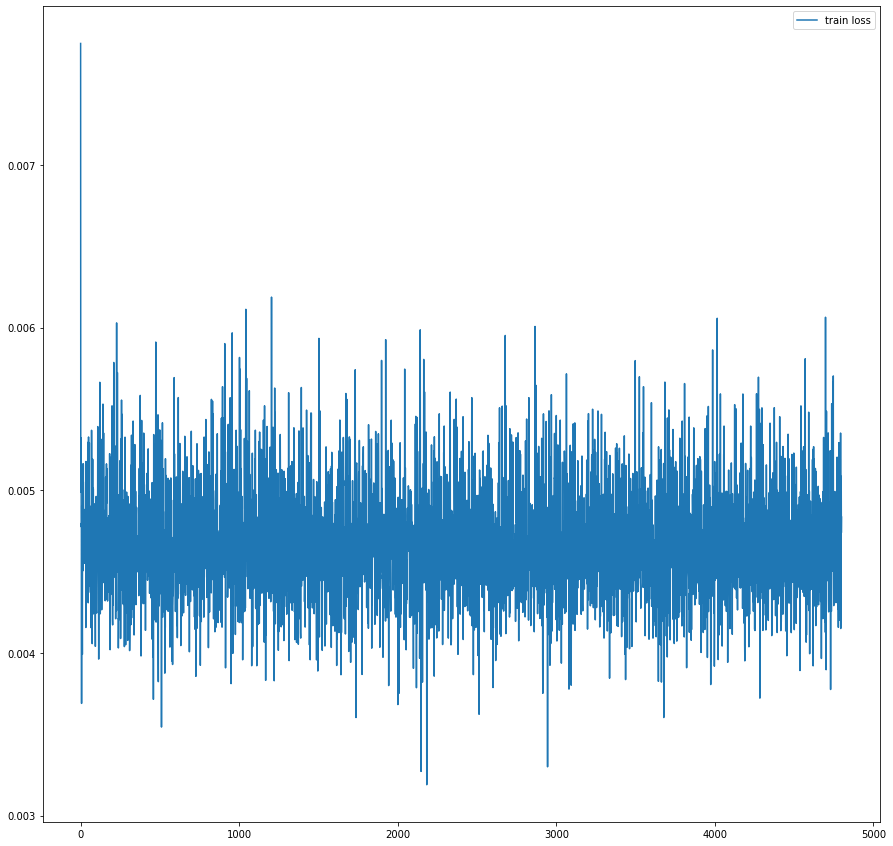

In [55]:
plot_loss(loss_history1)

### Model 2 - Accuracy - 75

In [107]:
# Declare Siamese Network
net2 = SiameseNetwork2().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net2.parameters(), lr=0.00001)#, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.8)
#scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 20, gamma = 0.1)
#optimizer = torch.optim.SGD(net2.parameters(), lr=0.00001, momentum=0.8)

In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model2,loss_history2 = train(net2,criterion)
torch.save(model2.state_dict(), "./model/model2.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 0.5288229584693909
 Learning Rate 1e-05

Epoch number 0
 Current loss 0.2813783884048462
 Learning Rate 1e-05

Epoch number 0
 Current loss 0.3046962022781372
 Learning Rate 1e-05

Epoch number 0
 Current loss 0.30651167035102844
 Learning Rate 1e-05

Epoch number 0
 Current loss 0.2643905282020569
 Learning Rate 1e-05

Epoch number 0
 Current loss 0.2519254684448242
 Learning Rate 1e-05

Epoch number 0
 Current loss 0.2375900000333786
 Learning Rate 1e-05

Epoch number 1
 Current loss 0.25854483246803284
 Learning Rate 1e-05

Epoch number 1
 Current loss 0.24269452691078186
 Learning Rate 1e-05

Epoch number 1
 Current loss 0.25600582361221313
 Learning Rate 1e-05

Epoch number 1
 Current loss 0.25512510538101196
 Learning Rate 1e-05

Epoch number 1
 Current loss 0.2738563120365143
 Learning Rate 1e-05

Epoch number 1
 Current loss 0.2710619568824768
 Learning Rate 1e-05

Epoch number 1
 Current loss 0.2599080502986908
 Learning Rate 1e-05

Epoch number 2


Epoch number 16
 Current loss 0.24490375816822052
 Learning Rate 1e-05

Epoch number 16
 Current loss 0.24716082215309143
 Learning Rate 1e-05

Epoch number 17
 Current loss 0.2561086416244507
 Learning Rate 1e-05

Epoch number 17
 Current loss 0.23601886630058289
 Learning Rate 1e-05

Epoch number 17
 Current loss 0.2502884268760681
 Learning Rate 1e-05

Epoch number 17
 Current loss 0.2468062788248062
 Learning Rate 1e-05

Epoch number 17
 Current loss 0.24720601737499237
 Learning Rate 1e-05

Epoch number 17
 Current loss 0.2367819845676422
 Learning Rate 1e-05

Epoch number 17
 Current loss 0.2497602105140686
 Learning Rate 1e-05

Epoch number 18
 Current loss 0.263544499874115
 Learning Rate 1e-05

Epoch number 18
 Current loss 0.25436389446258545
 Learning Rate 1e-05

Epoch number 18
 Current loss 0.27043408155441284
 Learning Rate 1e-05

Epoch number 18
 Current loss 0.2596588730812073
 Learning Rate 1e-05

Epoch number 18
 Current loss 0.26869380474090576
 Learning Rate 1e-05



Epoch number 33
 Current loss 0.2566834092140198
 Learning Rate 1e-05

Epoch number 33
 Current loss 0.24258431792259216
 Learning Rate 1e-05

Epoch number 33
 Current loss 0.2436240315437317
 Learning Rate 1e-05

Epoch number 33
 Current loss 0.2369564175605774
 Learning Rate 1e-05

Epoch number 33
 Current loss 0.245131254196167
 Learning Rate 1e-05

Epoch number 33
 Current loss 0.25069567561149597
 Learning Rate 1e-05

Epoch number 34
 Current loss 0.26462990045547485
 Learning Rate 1e-05

Epoch number 34
 Current loss 0.2650076448917389
 Learning Rate 1e-05

Epoch number 34
 Current loss 0.2548137307167053
 Learning Rate 1e-05

Epoch number 34
 Current loss 0.2423514425754547
 Learning Rate 1e-05

Epoch number 34
 Current loss 0.27658092975616455
 Learning Rate 1e-05

Epoch number 34
 Current loss 0.27107787132263184
 Learning Rate 1e-05

Epoch number 34
 Current loss 0.2710210680961609
 Learning Rate 1e-05

Epoch number 35
 Current loss 0.26326102018356323
 Learning Rate 1e-05

E

Epoch number 49
 Current loss 0.2581908106803894
 Learning Rate 1e-05

Epoch number 49
 Current loss 0.24891166388988495
 Learning Rate 1e-05

Epoch number 49
 Current loss 0.2525758147239685
 Learning Rate 1e-05

Model Saved Successfully


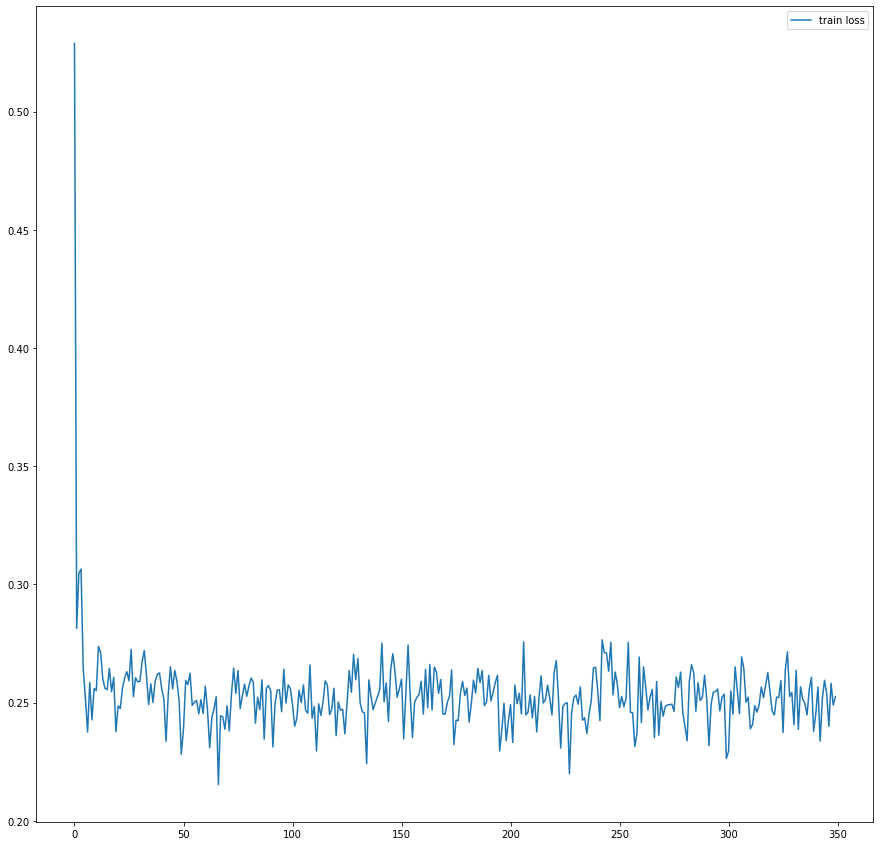

In [109]:
plot_loss(loss_history2)

### Model 3 - Accuracy - 49

In [64]:
# Declare Siamese Network
net3 = SiameseNetwork3().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net3.parameters(), lr=1e-4, alpha=0.99) #optim.RMSprop(net3.parameters(), lr=0.00001, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.8)
#optimizer = torch.optim.SGD(net3.parameters(), lr=0.00001, momentum=0.8)

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model3,loss_history3 = train(net3,criterion)
torch.save(model3.state_dict(), "./model/model3.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 0.424241840839386
 Learning Rate 0.0001

Epoch number 0
 Current loss 0.31384873390197754
 Learning Rate 0.0001

Epoch number 0
 Current loss 0.29964858293533325
 Learning Rate 0.0001

Epoch number 0
 Current loss 0.3386637568473816
 Learning Rate 0.0001

Epoch number 0
 Current loss 0.2885315716266632
 Learning Rate 0.0001

Epoch number 0
 Current loss 0.2958274483680725
 Learning Rate 0.0001

Epoch number 0
 Current loss 0.2826126217842102
 Learning Rate 0.0001

Epoch number 1
 Current loss 0.2901740074157715
 Learning Rate 0.0001

Epoch number 1
 Current loss 0.29592007398605347
 Learning Rate 0.0001

Epoch number 1
 Current loss 0.2842690944671631
 Learning Rate 0.0001

Epoch number 1
 Current loss 0.277191162109375
 Learning Rate 0.0001

Epoch number 1
 Current loss 0.2514732778072357
 Learning Rate 0.0001

Epoch number 1
 Current loss 0.2822186350822449
 Learning Rate 0.0001

Epoch number 1
 Current loss 0.29649996757507324
 Learning Rate 0.0001

Epoc

In [ ]:
plot_loss(loss_history3)

### Testing

In [110]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=data_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      #transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

### Prediction Model 1

In [63]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork1().to(device)
model.load_state_dict(torch.load("./model/model1.pt"))

<All keys matched successfully>

In [64]:
# Print the sample outputs to view its dissimilarity
pos = 0
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if eucledian_distance.item() <= 0.4:
        pred = 0.0
    else:
        pred = 1.0
        
    if pred == label.item():
        pos+=1
        
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
        
accuracy = pos/len(test_dataloader)
print('Accuracy : ',accuracy)

Accuracy :  0.5059237536656892


### Prediction Model 2

In [111]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork2().to(device)
model.load_state_dict(torch.load("./model/model2.pt"))

<All keys matched successfully>

In [112]:
from sklearn.metrics import confusion_matrix

# Print the sample outputs to view its dissimilarity
pos = 0
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
pred_lis = []
label_lis = []
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if eucledian_distance.item() <= 0.4:
        pred = 0.0
    else:
        pred = 1.0
        
    pred_lis.append(pred)
    label_lis.append(label.item())
        
    if pred == label.item():
        pos+=1
        
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
    
accuracy = pos/len(test_dataloader)
print('Accuracy : ',accuracy)

Accuracy :  0.5691512279190004


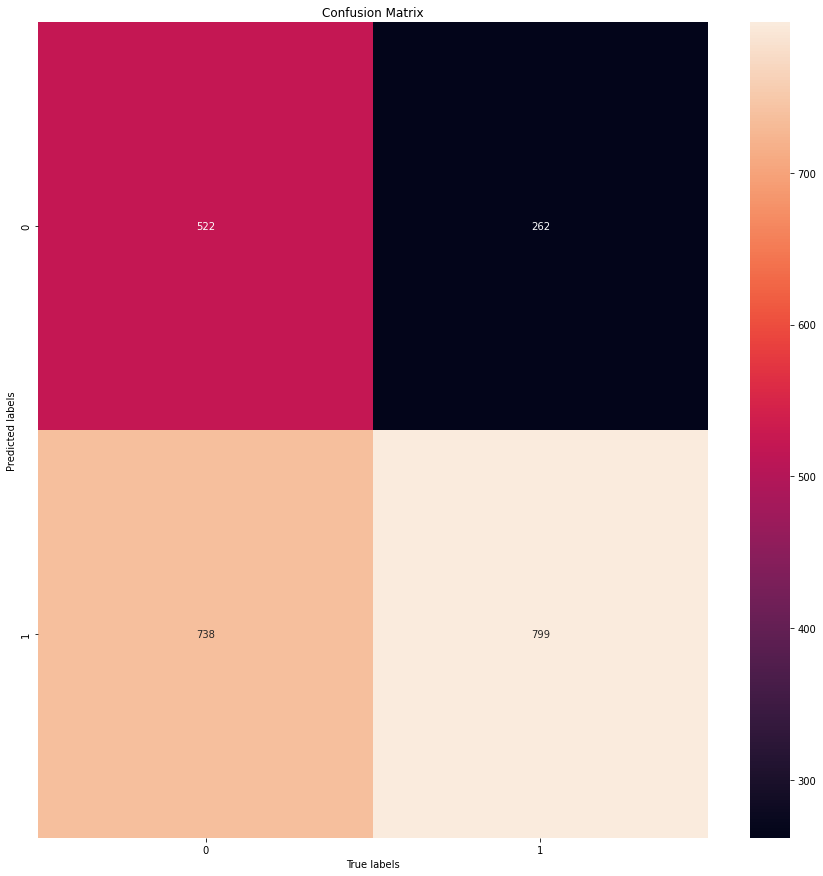

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(pred_lis, label_lis, labels=[0,1])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_ylabel('Predicted labels');ax.set_xlabel('True labels'); 
ax.set_title('Confusion Matrix'); 

### Prediction Model 3

In [71]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork3().to(device)
model.load_state_dict(torch.load("./model/model3.pt"))

<All keys matched successfully>

In [73]:
# Print the sample outputs to view its dissimilarity
pos = 0
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if eucledian_distance.item() <= 0.5:
        pred = 0.0
    else:
        pred = 1.0
        
    if pred == label.item():
        pos+=1
        
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
        
accuracy = pos/len(test_dataloader)
print('Accuracy : ',accuracy)

Accuracy :  0.5657044377423525


## Final Touch 

Thats it guys ! I am limited by time , computational power and knowledge .to get standard accuracy . But anyway this is the working code of Siamese Neural Network and you can try it for your own applications and dataset.

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Thanks to Gupta Blog : https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e